In [ ]:
## Batch size 16- Grad Cam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-27 22:38:28.262999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745807908.282497   32301 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745807908.288416   32301 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745807908.303681   32301 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745807908.303703   32301 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745807908.303706   32301 computation_placer.cc:177] computation placer alr

In [2]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

## Resolution: 64x64

### ResNet50_64

In [ ]:
## GramCam for ORIGINAL CODE with batch size 16, no attention layer, no class-weighted, dropout rate 0.3, Adam(1e-3)

In [21]:
import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image 

# 1) model details
model = model_50_64  
img_size = (64, 64)  
preprocess_input = lambda x: x / 255.0  

# 2) find last conv layer name 
model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 70,706,074 (269.72 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,101,970 (179.68 MB)

In [22]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [23]:
# 3) prepare image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image.open(cam_path))

In [ ]:
# path: /shared/home/tzj255/bmi707_fp/image/pixel/image.jpg

# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

!ls ./image/64

Predicted class: 0


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_348']]
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


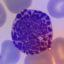

In [24]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/basophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


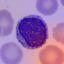

In [25]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/lymphocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 1


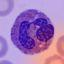

In [26]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/eosinophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


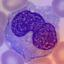

In [27]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/monocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 2


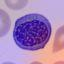

In [28]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/erythroblast_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 6


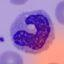

In [29]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/neutrophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


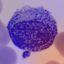

In [30]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/immature_granulocytes_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


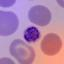

In [31]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/platelet_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

In [ ]:
########### Batch size 16, no attention layer, YES weighted-loss, dropout 0.3, Adam(1e-4) ###########

In [3]:
# 1. Load dataset
data_64 = np.load("bloodmnist_64.npz")

# 2. Extract images and labels
train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"].flatten()

val_images_64 = data_64["val_images"]
val_labels_64 = data_64["val_labels"].flatten()

test_images_64 = data_64["test_images"]
test_labels_64 = data_64["test_labels"].flatten()

In [4]:
data_64.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [5]:
# 3. One-hot encode labels
train_labels_cat_64 = to_categorical(train_labels_64, num_classes=8)
val_labels_cat_64 = to_categorical(val_labels_64, num_classes=8)
test_labels_cat_64 = to_categorical(test_labels_64, num_classes=8)

In [6]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16

train_generator_64 = train_datagen.flow(
    train_images_64, 
    train_labels_cat_64,   
    batch_size=batch_size
)
val_generator_64 = test_datagen.flow(
    val_images_64,
    val_labels_cat_64,
    batch_size=batch_size
)
test_generator_64 = test_datagen.flow(
    test_images_64,
    test_labels_cat_64,
    batch_size=batch_size,
    shuffle=False
)

In [7]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

# not applying attention layer for this comparison
# x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
# attention = layers.Attention()([x_reshape, x_reshape])
# attention_output = layers.Reshape(x.shape[1:])(attention)

# x = layers.Multiply()([x, attention_output]) # apply attention layer

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.3)(x) 

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

2025-04-27 22:39:40.260055: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# 6. Compile model 
print("Batch Size Comparison: ResNet50 (64x64), batch size 16, no attention layer, dropout rate 0.3")

# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

Batch Size Comparison: ResNet50 (64x64), batch size 16, no attention layer, dropout rate 0.3
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


748/748 ━━━━━━━━━━━━━━━━━━━━ 578s 736ms/step - accuracy: 0.7365 - auc: 0.9389 - loss: 0.7996 - val_accuracy: 0.1402 - val_auc: 0.5759 - val_loss: 5.3372
Epoch 2/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 546s 730ms/step - accuracy: 0.9311 - auc: 0.9940 - loss: 0.2009 - val_accuracy: 0.9609 - val_auc: 0.9975 - val_loss: 0.1217
Epoch 3/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 547s 732ms/step - accuracy: 0.9527 - auc: 0.9966 - loss: 0.1379 - val_accuracy: 0.9574 - val_auc: 0.9972 - val_loss: 0.1317
Epoch 4/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 548s 733ms/step - accuracy: 0.9664 - auc: 0.9974 - loss: 0.0985 - val_accuracy: 0.9679 - val_auc: 0.9976 - val_loss: 0.1033
Epoch 5/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 553s 739ms/step - accuracy: 0.9639 - auc: 0.9971 - loss: 0.1086 - val_accuracy: 0.9457 - val_auc: 0.9958 - val_loss: 0.1581
Epoch 6/10
748/748 ━━━━━━━━━━━━━━━━━━━━ 585s 782ms/step - accuracy: 0.9703 - auc: 0.9976 - loss: 0.0951 - val_accuracy: 0.9585 - val_auc: 0.9966 - val_loss: 0.1366
Epoch 7/10
748/748 ━━━━━━━━

In [9]:
model_50_64.save('model_50_64_batch16_noAttention.h5')
model_50_64.save('model_50_64_batch16_noAttention.keras')

In [10]:
# 8. Evaluate model
test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pixels:      {test_auc_50_64:.4f}")

214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9670 - auc: 0.9982 - loss: 0.0951
ResNet50 test accuracy for 64 pixels: 0.9699
ResNet50 test AUC for 64 pixels:      0.9984


In [11]:
# 9. Precision, recall, f1-score
y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step
                      precision    recall  f1-score   support

          neutrophil       0.89      1.00      0.94       244
          eosinophil       0.99      1.00      1.00       624
            basophil       1.00      0.96      0.98       311
          lymphocyte       0.95      0.90      0.93       579
            monocyte       0.98      0.99      0.98       243
immature granulocyte       0.95      0.98      0.97       284
        erythroblast       0.97      0.98      0.97       666
            platelet       1.00      0.99      0.99       470

            accuracy                           0.97      3421
           macro avg       0.97      0.97      0.97      3421
        weighted avg       0.97      0.97      0.97      3421



In [12]:
# 10. Performance per class
cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9959
eosinophil           accuracy: 0.9968
basophil             accuracy: 0.9582
lymphocyte           accuracy: 0.9033
monocyte             accuracy: 0.9877
immature granulocyte accuracy: 0.9789
erythroblast         accuracy: 0.9775
platelet             accuracy: 0.9851


Found History outputs in cells: [8]


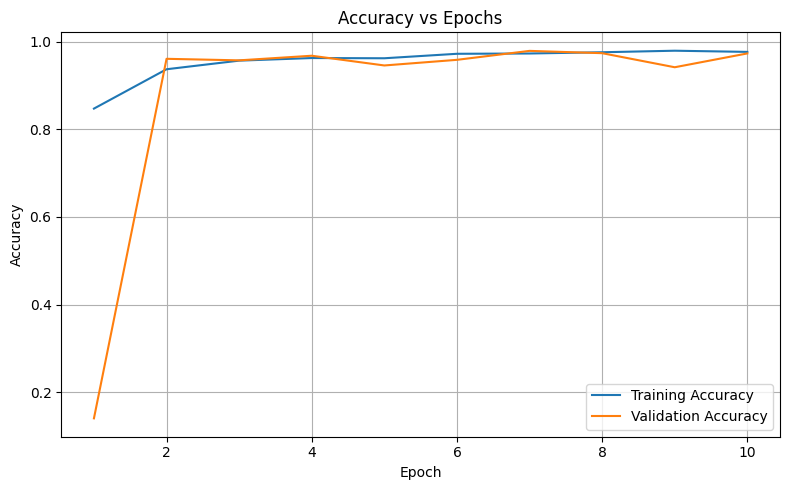

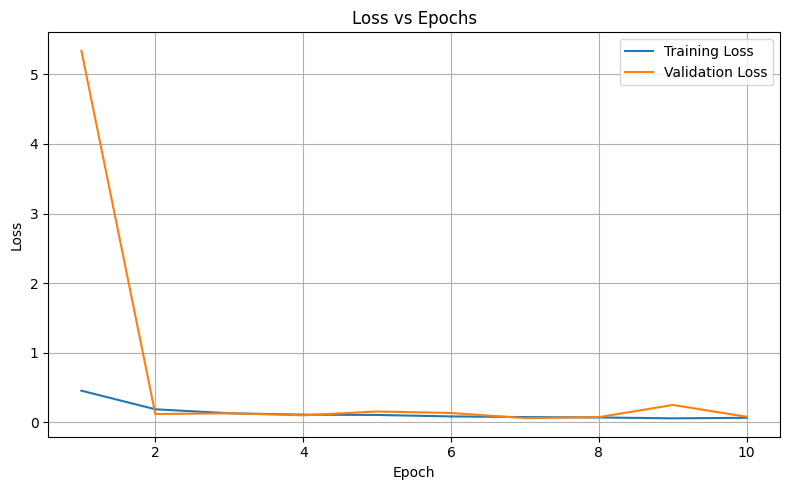

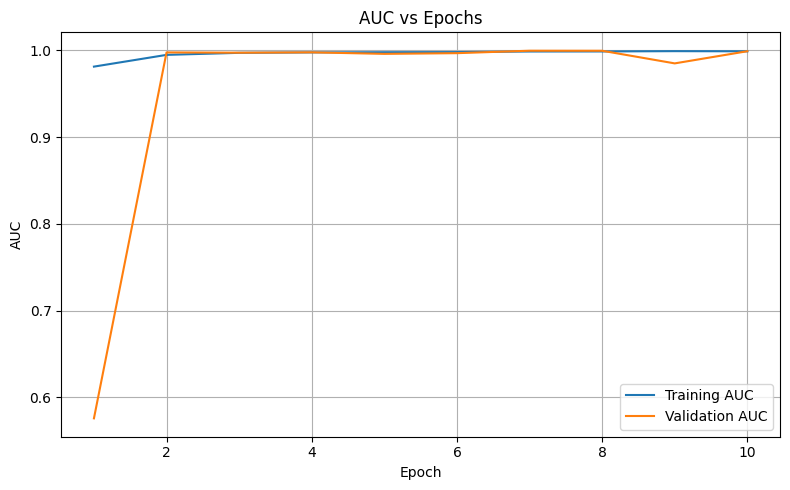

In [13]:
from tensorflow.keras.callbacks import History as HistoryClass

ip = get_ipython()
outs = ip.user_ns["Out"]

# find all history outputs
history_cells = [num for num, obj in outs.items() if isinstance(obj, HistoryClass)]
print("Found History outputs in cells:", history_cells)

# get the most recent history
history = outs[history_cells[-1]]  

epochs = range(1, len(history.history['loss']) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['auc'], label='Training AUC')
plt.plot(epochs, history.history['val_auc'], label='Validation AUC')
plt.title('AUC vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## GramCam for batch size 16, no attention layer, YES class-weighted, dropout rate 0.3, Adam(1e-3)

In [14]:
import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image 

In [15]:
# 1) model details
model = model_50_64  
img_size = (64, 64)  
preprocess_input = lambda x: x / 255.0  

In [16]:
# 2) find last conv layer name 
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 70,706,074 (269.72 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,101,970 (179.68 MB)

In [24]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [25]:
# 3) prepare image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image.open(cam_path))

In [10]:
# path: /shared/home/tzj255/bmi707_fp/image/pixel/image.jpg

/shared/home/tzj255/bmi707_fp


In [ ]:
# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

In [33]:
!ls ./image/64

basophil_test_64.jpg		   lymphocyte_test_64.jpg
eosinophil_test_64.jpg		   monocyte_test_64.jpg
erythroblast_test_64.jpg	   neutrophil_test_64.jpg
immature_granulocytes_test_64.jpg  platelet_test_64.jpg


Predicted class: 0


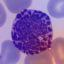

In [27]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/basophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


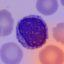

In [32]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/lymphocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 1


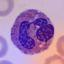

In [34]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/eosinophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


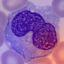

In [35]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/monocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


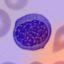

In [36]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/erythroblast_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 6


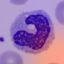

In [37]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/neutrophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


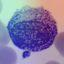

In [38]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/immature_granulocytes_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


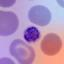

In [39]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/platelet_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)